# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*



# Additional convenient code

In [ ]:
# Generate a shuffled colormap to be used to color labeled images
def generate_shuffled_cmap(n_labels=255, seed=42):
    """ Generate a shuffled colormap to be used to color labeled images 
    (generated by ChatGPT) """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # Generate a colormap with n_labels distinct colors
    cmap = plt.cm.get_cmap('tab20', n_labels)
    pyplot.get_cmap()
    colors = cmap(np.arange(n_labels))

    # Shuffle the colors
    np.random.seed(seed)
    np.random.shuffle(colors)

    # Create a new colormap from the shuffled colors
    shuffled_cmap = mcolors.ListedColormap(colors)

    return shuffled_cmap

shuffled_map = generate_shuffled_cmap()

/var/folders/8w/2thz_cgn3xn13rhrxb2dvb5w0000gn/T/ipykernel_47589/3440364377.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_labels)


# Collect the relevant code we had earlier

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
import numpy as np

import skimage as sk
from scipy import stats
from scipy import ndimage

FIGSIZE21 = (10/2.54,5/2.54) 
FIGSIZE22 = (10/2.54,10/2.54) 

In [9]:
def my_plot_12(img1, img2, mycmap='viridis'):
    # plot two images side by side
    fig, axs = plt.subplots(1,2, figsize=FIGSIZE21)
    _ = axs[0].imshow(img1, cmap=mycmap)
    _ = axs[1].imshow(img2, cmap=mycmap)  
    plt.tight_layout()  
    
def my_plot_1(img1, mycmap='gray', myfigsize=(5/2.54,5/2.54)):
    fig, ax = plt.subplots(1,1, figsize=myfigsize)
    _=plt.imshow(img1, cmap=mycmap)   

In [4]:
# Let's also load an image of some bacteria (Wehrens et al.)
path_img_ecoli = '../images/biological/microcolony_ecoli.tif'
img_ecoli = tiff.imread(path_img_ecoli)
# invert image
img_ecoli_inv = np.max(img_ecoli)-img_ecoli

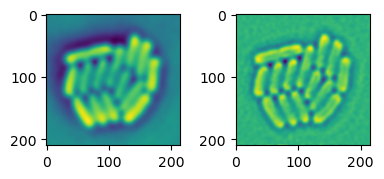

In [8]:
# Show the results of LoG on the bacteria
img_ecoli_gauss = sk.filters.gaussian(img_ecoli_inv, sigma=3)
edges_log = sk.filters.laplace(img_ecoli_gauss)
# show both
my_plot_12(img_ecoli_gauss, edges_log, mycmap='viridis')

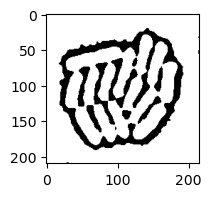

In [10]:
# Threshold edges_log by triangle method
mask_ecoli_log = edges_log > sk.filters.threshold_triangle(edges_log)
my_plot_1(mask_ecoli_log)

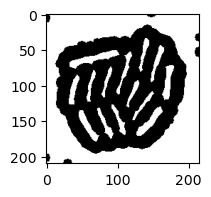

In [11]:
# Let's erode this by 5 px
mask_ecoli_log_eroded = sk.morphology.erosion(mask_ecoli_log, footprint=sk.morphology.disk(5))

# Show
my_plot_1(mask_ecoli_log_eroded)

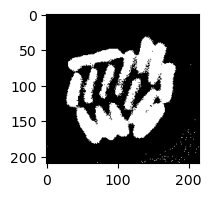

In [14]:
# Triangle threshold
mask_ecoli_triangle = img_ecoli_inv > sk.filters.threshold_triangle(img_ecoli_inv)
my_plot_1(mask_ecoli_triangle)

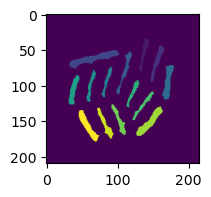

In [15]:
# Let's combine with our original triangle mask

# first remove small objects
mask_ecoli_triangle_filtered   = sk.morphology.remove_small_objects(mask_ecoli_triangle, min_size=50)
mask_ecoli_log_eroded_filtered = sk.morphology.remove_small_objects(mask_ecoli_log_eroded, min_size=50)

# Combine
mask_bacteria_slim = np.logical_and(mask_ecoli_triangle_filtered, mask_ecoli_log_eroded)
# And label
mask_bacteria_slim_labeled = sk.measure.label(mask_bacteria_slim)
my_plot_1(mask_bacteria_slim_labeled, mycmap='viridis')

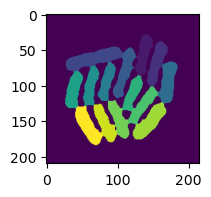

In [16]:
# This is a great tool to separate one of earlier bacterial images.
# Apply watershed to mask_ecoli_log, using mask_bacteria_slim_labeled as seeds
mask_bacteria_combined = sk.segmentation.watershed(-edges_log, markers=mask_bacteria_slim_labeled, mask=mask_ecoli_log)

# Show the result
my_plot_1(mask_bacteria_combined, mycmap='viridis')

# Creating sensible functions to achieve segmentation

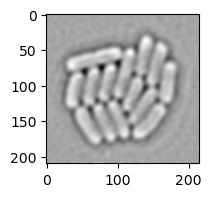

In [21]:
# (img_ecoli_inv needs to be loaded earlier)


def my_detect_edges(the_img):
    """ Detect edges using LoG (Laplacian of Gaussian) """
    the_img = sk.filters.gaussian(the_img, sigma=3)
    the_img = sk.filters.laplace(the_img)
    return the_img

img_ecoli_edges = my_detect_edges(img_ecoli_inv)
my_plot_1(img_ecoli_edges)

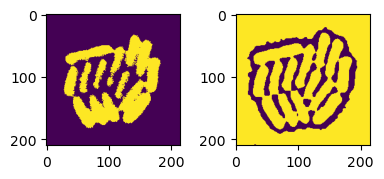

In [32]:

def apply_triangle_n_polish(the_img):
    """ Apply triangle threshold and remove small parts"""
    the_mask = the_img > sk.filters.threshold_triangle(the_img)
    the_mask_filtered = sk.morphology.remove_small_objects(the_mask, min_size=50)
    return the_mask_filtered

mask_ecoli = apply_triangle_n_polish(img_ecoli_inv)
mask_ecoli_edges = apply_triangle_n_polish(img_ecoli_edges)

my_plot_12(mask_ecoli, mask_ecoli_edges)


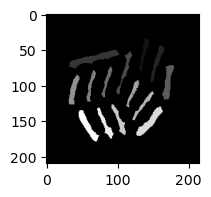

In [40]:

# Get foreground 
mask_foreground = sk.morphology.dilation(mask_ecoli, footprint=sk.morphology.disk(5))

def produce_seeds(mask_ecoli_edges, mask_foreground):
    """ Combine edge and raw mask to produce regions that correspond to 
    single E. coli, which can be used as seeds."""
    
    # Let's erode this by 5 px
    mask_ecoli_edges_eroded = sk.morphology.erosion(mask_ecoli_edges, footprint=sk.morphology.disk(5))

    # Combine them to get seeds
    mask_seeds = np.logical_and(mask_ecoli_edges_eroded, 
                                mask_foreground)
    
    # Label
    mask_seeds_labeled = sk.measure.label(mask_seeds)
    
    return mask_seeds_labeled

mask_seeds_labeled = produce_seeds(mask_ecoli_edges, mask_ecoli)

# my_plot_12(mask_ecoli_edges_eroded, mask_ecoli_dilated)
my_plot_1(mask_seeds_labeled)


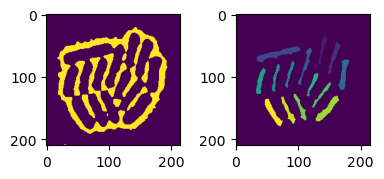

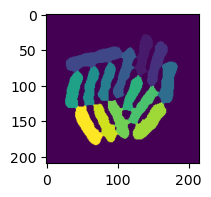

In [63]:

# Apply the watershed    
mask_bacteria_watershed = sk.segmentation.watershed(~mask_ecoli_edges, markers=mask_seeds_labeled, mask=mask_ecoli_log)

my_plot_12(~mask_ecoli_edges, mask_seeds_labeled)

# Show the result
my_plot_1(mask_bacteria_watershed, mycmap='viridis')

# The segmentation strategy using subfunctions

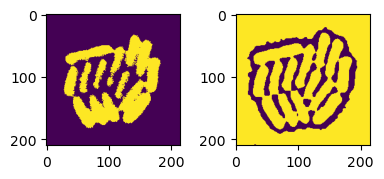

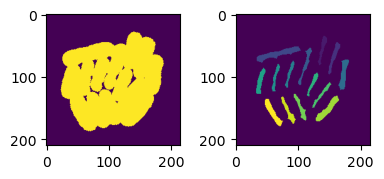

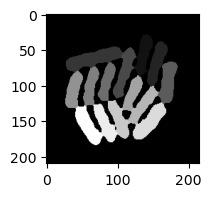

In [69]:
#def segment_bacterial_img(img_ecoli):
#    """ Combine multiple operations to get segmented image from microscopy picture """
    
img_ecoli_inv = np.max(img_ecoli)-img_ecoli
img_ecoli_edges = my_detect_edges(img_ecoli_inv)
mask_ecoli = apply_triangle_n_polish(img_ecoli_inv)
mask_ecoli_edges = apply_triangle_n_polish(img_ecoli_edges)
my_plot_12(mask_ecoli, mask_ecoli_edges)

mask_foreground = sk.morphology.dilation(mask_ecoli, footprint=sk.morphology.disk(5))
mask_seeds_labeled = produce_seeds(mask_ecoli_edges, mask_foreground)
my_plot_12(mask_foreground, mask_seeds_labeled)

mask_ecoli_watershed = sk.segmentation.watershed(~mask_ecoli_edges, markers=mask_seeds_labeled, mask=mask_ecoli_edges)
my_plot_1(mask_ecoli_watershed)    
    

# Creating one segmentation function

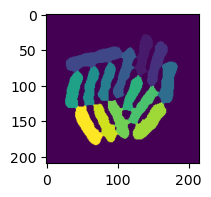

In [72]:
def segment_bacterial_img(img_ecoli):
    """ Combine multiple operations to get segmented image from microscopy picture """
        
    img_ecoli_inv = np.max(img_ecoli)-img_ecoli
    img_ecoli_edges = my_detect_edges(img_ecoli_inv)
    mask_ecoli = apply_triangle_n_polish(img_ecoli_inv)
    mask_ecoli_edges = apply_triangle_n_polish(img_ecoli_edges)
    # my_plot_12(mask_ecoli, mask_ecoli_edges)

    mask_foreground = sk.morphology.dilation(mask_ecoli, footprint=sk.morphology.disk(5))
    mask_seeds_labeled = produce_seeds(mask_ecoli_edges, mask_foreground)
    # my_plot_12(mask_foreground, mask_seeds_labeled)

    mask_ecoli_watershed = sk.segmentation.watershed(~mask_ecoli_edges, markers=mask_seeds_labeled, mask=mask_ecoli_edges)
    # my_plot_1(mask_ecoli_watershed)   
    
    return mask_ecoli_watershed

mask_ecoli_watershed = segment_bacterial_img(img_ecoli)
my_plot_1(mask_ecoli_watershed, mycmap='viridis')

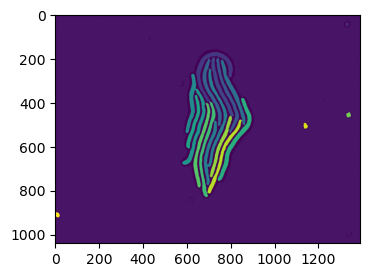

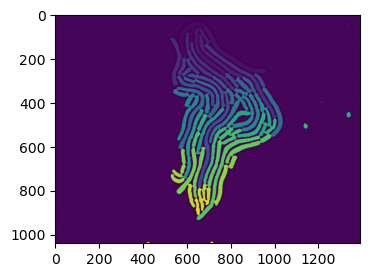

In [75]:
# now apply it to a few other images

# 1247
img_ecoli_1247 = tiff.imread('/Users/m.wehrens/Data_notbacked/2025_Py-Image-wokshop_Filamentation-example-data/images/pos3crop-p-2-1247.tif')
mask_ecoli_1247 = segment_bacterial_img(img_ecoli_1247)
my_plot_1(mask_ecoli_1247, mycmap='viridis', myfigsize=(10/2.54,10/2.54))

# 1498
img_ecoli_1498 = tiff.imread('/Users/m.wehrens/Data_notbacked/2025_Py-Image-wokshop_Filamentation-example-data/images/pos3crop-p-2-1498.tif')
mask_ecoli_1498 = segment_bacterial_img(img_ecoli_1498)
my_plot_1(mask_ecoli_1498, mycmap='viridis', myfigsize=(10/2.54,10/2.54))
